# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


#  Reading data

In [4]:
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 5s')
dataset= df.copy()

#  Exploring the data

In [ ]:
dataset.head()
dataset.tail()

In [5]:
column_names = ['DEPTH', 'SP', 'RHOB', 'NPHI','ILD','GR']

In [7]:
dataset.describe()

,DEPTH,SP,RHOB,NPHI,ILD,GR
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,1671.529747,80.460291,2.223081,0.435640,5.829968,36.159651
std,222.049495,7.590529,0.218437,0.138693,10.350587,8.808237
min,1284.122400,67.884400,1.060000,0.053700,0.564300,14.605700
25%,1481.061300,74.472150,2.156500,0.295900,2.097625,29.862700
50%,1671.599400,79.268350,2.260000,0.482400,2.626900,34.764300
75%,1865.337900,84.794450,2.368000,0.537100,3.916050,40.922475
max,2054.961600,106.062500,2.720000,0.771500,175.064500,73.442600


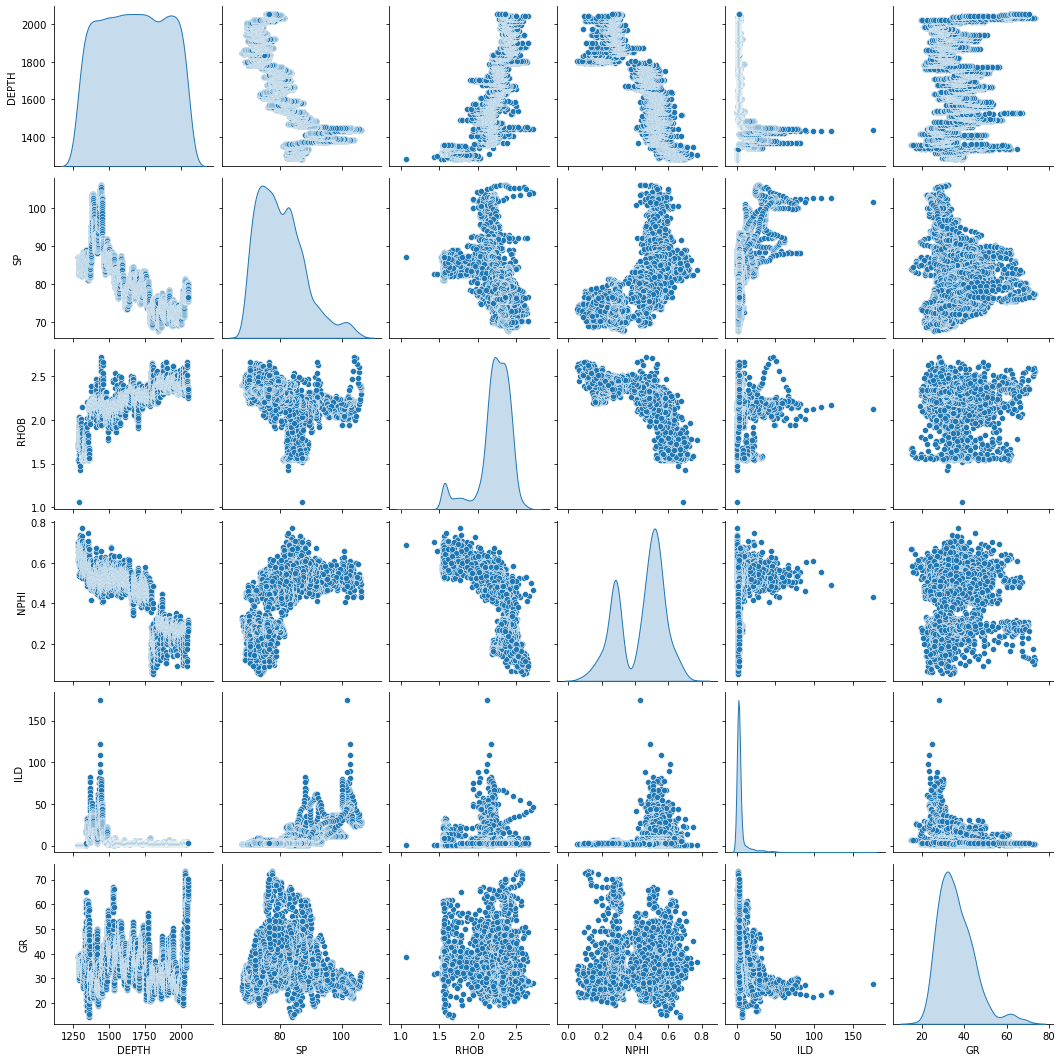

In [9]:
sns.pairplot(dataset[column_names], diag_kind='kde')

### Clean the data

In [8]:
# If the dataset contains a few unknown values.

dataset.isna().sum()

#if so Drop those rows to keep this initial tutorial simple.

dataset = dataset.dropna()

#then confirm drop
dataset.isna().sum()

# help(dataset.sample)

DEPTH    0
SP       0
RHOB     0
NPHI     0
ILD      0
GR       0
dtype: int64

In [ ]:
#### Split the data into train and test

In [10]:
# the 'sample' method takes a certain fraction randomly
#Note that we use `random_state` to ensure the reproducibility of the examples.
train_dataset = dataset.sample(frac=0.7, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
# Inspect the data
# Have a quick look at the joint distribution of a few pairs of columns from the training set.
# (   ) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other

sns.pairplot(train_dataset[column_names], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

##### Splitting the train and test data into input and target

In [12]:

# split datat into input and target

train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_target = train_input.pop('RHOB')
test_target = test_input.pop('RHOB')



In [ ]:

train_input.head()
# type(train_input)

# A DNN regression¶
These models will contain a few more layers than the linear model:

###     1. The normalization layer.
###    2. Two hidden, nonlinear, Dense layers using the relu nonlinearity.
###    3. A linear single-output layer.

### normalization
The normalisation layer
Normalization layer is a clean and simple way to build that preprocessing into your mode

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
DEPTH,1669.686629,222.110993
SP,80.522702,7.647740
RHOB,2.222204,0.218266
NPHI,0.436384,0.137932
ILD,5.920798,10.589117
GR,36.177188,8.811776


In [14]:
normalizer = preprocessing.Normalization()

#then adapt it to the data
normalizer.adapt(np.array(train_input))

# This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

[1.6696866e+03 8.0522705e+01 4.3638378e-01 5.9207983e+00 3.6177189e+01]


In [ ]:
# When the layer is called it returns the input data, with each feature independently normalized:

first = np.array(train_input[:2])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

In [26]:
# A function to hold 
def FFBackProp(inputs, output):
    #normalization
    normalizer=preprocessing.Normalization()
    #then adapt it to the data
    normalizer.adapt(np.array(inputs))
    
    
    #  Create layers
    l0=normalizer
    #Dense layers using the relu nonlinearity.
    l1=tf.keras.layers.Dense(64,activation="relu", input_shape=(5,))
    l2=tf.keras.layers.Dense(64,activation="relu") #activation=sigmoid
    #A linear output layer
    l3=tf.keras.layers.Dense(1)
    
    
#     create the model with the layers formed
    model1 =tf.keras.models.Sequential([l0,l1,l2,l3])
    
    
#     compile the model
    model1.compile(optimizer='adam',
                loss='mean_absolute_error', #(from_logits=True),
                metrics=["accuracy"]
               )
    
    model1.summary()
    
    return model1
    
myFFBP= FFBackProp(train_input,train_target)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


### Train the model

In [28]:
%%time
myFFBPtraining = myFFBP.fit(
    train_input, train_target,
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=0,
    epochs=100)

Wall time: 21.6 s


In [39]:
# dir(myFFBPtraining.history{'loss'})
# help(tf.keras.losses.Loss)

In [ ]:
# Evaluate

### with visualization

In [29]:
# collect the results in a set
test_results={}

test_results['FFBP'] = myFFBP.evaluate(test_input, test_target, verbose=0)

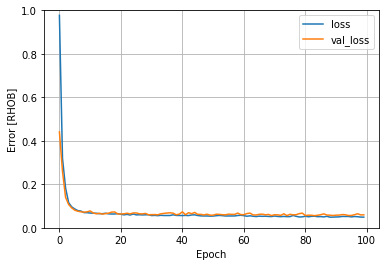

In [30]:
# a function to plot loss 
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(myFFBPtraining)

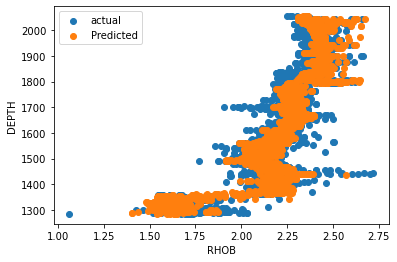

In [46]:
# A function to plot the predicted and actual target against a similar DEPTH


target1=train_target

test_prediction = myFFBP.predict(test_input).flatten() ##Flattening converts multidimensional lists into one-dimensional lists


def plot_Scatter(target1, test_prediction):
    plt.scatter(target1, train_input['DEPTH'],  label='actual')
    plt.scatter( test_prediction,  train_input['DEPTH'], label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plot_Scatter(x,y)

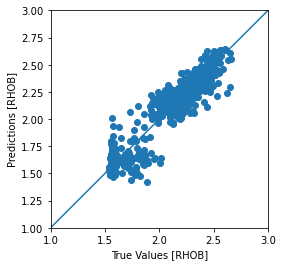

In [48]:
# Plot regression between predicted and actual
# test_predictions = dnn_model.predict(test_input).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_target, test_prediction)
plt.xlabel('True Values [RHOB]')
plt.ylabel('Predictions [RHOB]')
lims = [1, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


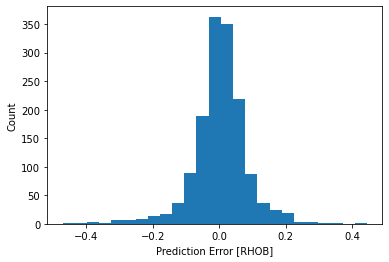

In [49]:
# Now take a look at the error distribution:

error = test_prediction - test_target
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [RHOB]')
_ = plt.ylabel('Count')


In [50]:
#MAE
tf.keras.losses.MAE(
    test_target, test_prediction
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.05691859>

In [53]:
MSE
tf.keras.losses.MSE(
 test_target, test_prediction
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0069041024>

In [55]:
#Compute R^2 score.

tfa.metrics.RSquare(
    name: str = 'r_square',
    dtype: tfa.types.AcceptableDTypes = None,
    y_shape: Tuple[int, ...] = (),
    multioutput: str = 'uniform_average',
    **kwargs
)

Calr2 = tfa.metrics.r_square.RSquare()
Calr2.update_state(test_target, test_prediction)
CalRR = metric.result()
CalRR.numpy()

SyntaxError: invalid syntax (<ipython-input-55-1be23a1a0092>, line 4)

# Testing model on different wells


In [57]:
# read different sheet from same excel book
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 4s')
dataset4s= df.copy()

In [58]:
# Split new data into input and target based on the training given the model

trial4s_input= dataset4s.copy() 
trial4s_target=trial4s_input.pop('RHOB')

trial4s_input.head()
trial4s_target.head()

0    1.7092
1    1.7035
2    1.6942
3    1.6868
4    1.6838
Name: RHOB, dtype: float64

In [63]:
# test new data with model

myFFBP.evaluate(trial4s_input,trial4s_target, verbose=0)
# help(myFFBP.evaluate)


[0.4146657884120941, 0.0]

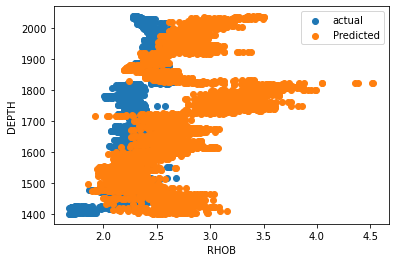

In [64]:
# A function to plot scatter
#where i try to compare the predicted and the actual target against the DEPTH

x=trial4s_target
prediction4s = myFFBP.predict(trial4s_input)

def plot_Scatter4s(target4s, predict4s):
    
    plt.scatter(target4s, trial4s_input['DEPTH'],  label='actual')
    plt.scatter( predict4s, trial4s_input['DEPTH'], label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plot_Scatter4s(trial4s_target,prediction4s)

slope is [2.28193329]


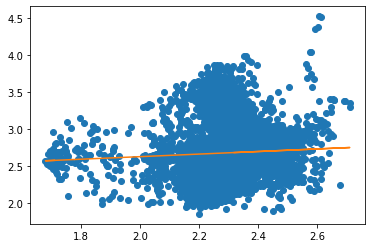

In [72]:
def plot_Regression4s(target4s, predict4s):
    
    plt.plot(target4s, predict4s, "o") #create the scatter plot
    m, b = np.polyfit(target4s, predict4s, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope is" , np.array(b))
    
    
plot_Regression4s(trial4s_target,prediction4s)    
